In [2]:
%cd '../'

import os
import random

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.nn import functional as F
import torchmetrics.functional as M

import albumentations as A
from albumentations.pytorch import ToTensorV2

from model_pl import TorchLightNet
from generator import MyDataset
from make_data_frame import make_data_frame
from settings import exp, csv_folder, check_pointer_path, sub_exp, AVAIL_GPUS

from model import SNUNet

/mnt/md2/geoframework/models/rnd/happy_whale/model


In [3]:
dataset, df = make_data_frame(csv_folder,
                              'train_df.csv',
                              'validate_df.csv',
                              'test_df.csv')
train = df.get('train')
validate = df.get('validate')

batch_size = 64
train_full_batch = (train.shape[0] // batch_size) * batch_size

train_transform = A.Compose(
    [
        A.Resize(width=128, height=128),
        A.CenterCrop(width=64, height=64),
        A.HorizontalFlip(p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.25),
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.Normalize(mean=0, std=1),
        ToTensorV2(),
    ],
    additional_targets={'image_b': 'image'}
)
train_dataset = MyDataset(train[:train_full_batch], transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=6)

val_transform = A.Compose(
    [
        A.Resize(width=64, height=64),
        A.Normalize(mean=0, std=1),
        ToTensorV2(),
    ],
    additional_targets={'image_b': 'image'}
)
val_dataset = MyDataset(validate, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, shuffle=False, num_workers=6)

In [4]:
device = torch.device('cpu')
model = SNUNet()
model.to(device)

im_a = inputs['first']
im_b = inputs['second']

im_a = im_a.to(device, dtype=torch.float)
im_b = im_b.to(device, dtype=torch.float)
labels = labels.to(device, dtype=torch.float)

out = model(im_a, im_b)

In [5]:
out

tensor([[  2.1229],
        [  6.2633],
        [-10.5971],
        [ -6.6517],
        [  2.9513]], grad_fn=<AddmmBackward>)

In [6]:
logits = torch.sigmoid(out)
logits

tensor([[8.9310e-01],
        [9.9810e-01],
        [2.4988e-05],
        [1.2902e-03],
        [9.5032e-01]], grad_fn=<SigmoidBackward>)

In [9]:
labels = torch.unsqueeze(labels, dim=1)
labels.shape

torch.Size([5, 1])

In [22]:
labels

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.]])

In [10]:
loss = F.binary_cross_entropy_with_logits(logits, labels)
loss

tensor(1.0422, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [21]:
threshold = torch.tensor([0.5])

preds = (logits > threshold).float() * 1
preds

tensor([[1.],
        [1.],
        [0.],
        [0.],
        [1.]])

In [26]:
preds.int()

tensor([[1],
        [1],
        [0],
        [0],
        [1]], dtype=torch.int32)

In [25]:
acc = M.accuracy(preds.int(), labels.int())
acc

tensor(0.2000)

In [4]:
validate_ = validate[validate['label'] == 0]

val_transform = A.Compose(
    [
        A.Resize(width=224, height=224),
        A.Normalize(mean=0, std=1),
        ToTensorV2(),
    ],
    additional_targets={'image_b': 'image'}
)
val_dataset = MyDataset(validate_, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, shuffle=False, num_workers=6)

index, inputs, mask = next(iter(val_loader))

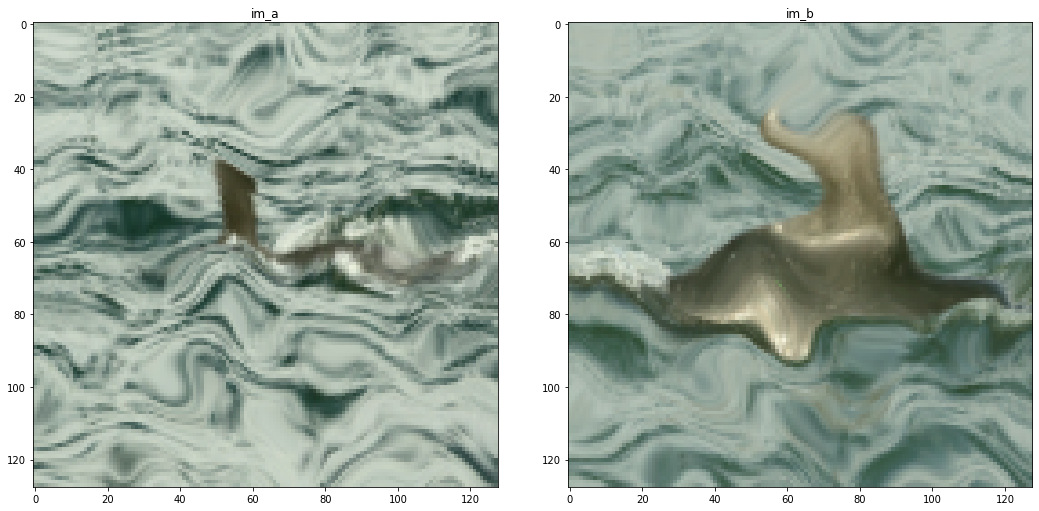

In [19]:
im_a = inputs['first'][0].numpy()
im_a = np.swapaxes(im_a, 0, 2)
im_a = np.swapaxes(im_a, 0, 1)

im_b = inputs['second'][0].numpy()
im_b = np.swapaxes(im_b, 0, 2)
im_b = np.swapaxes(im_b, 0, 1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

ax1.imshow(im_a, interpolation='nearest')
ax1.title.set_text('im_a')

ax2.imshow(im_b, interpolation='nearest')
ax2.title.set_text('im_b')

fig.tight_layout(rect=[0, 0.50, 1, 0.95])